In [1]:
!pip3 install https://download.pytorch.org/whl/cu80/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install torchsummary
!pip3 install tensorboardX

from google.colab import drive
drive.mount('/content/gdrive')
!cp gdrive/My\ Drive/x64/*.npy .
!cp gdrive/My\ Drive/*.py .
!ls -l

    100% |████████████████████████████████| 532.5MB 31kB/s 
fastai 1.0.50.post1 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: torch 1.0.1.post2
    Uninstalling torch-1.0.1.post2:
      Successfully uninstalled torch-1.0.1.post2
    100% |████████████████████████████████| 133kB 4.6MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
total 949908
-rw------- 1 root root      2875 Mar 30 20:36 _dataset_tools.py
drwx------ 3 root root      4096

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# from tensorboardX import SummaryWriter
from torchsummary import summary

import _my_tools as mt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is", device)
X_train, y_train, X_test, y_test = mt.loadData("",'float16',channels_last=False)

Device is cuda:0


In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.KERNEL_SIZE = 31
        self.activation = nn.ReLU()
        
        self.conv_setup = {
            'kernel' : (3,3),
            'stride' : (1,1),
            'padding' : 1,
            'activation' : self.activation
        }
        self.pooling_setup = {
            'kernel_size' : (2,2),
            'stride' : (2,2)
        }
        self.upsample_setup = {
            'scale_factor' : 2,
            'mode' : 'bilinear',
            'align_corners' : True
        }

        self.pooling_layer = nn.AvgPool2d(**self.pooling_setup)
        self.upsample_layer = nn.Upsample(**self.upsample_setup)
        
        self.conv32 = self._convBlock(2, 32, **self.conv_setup)
        self.conv64 = self._convBlock(32, 64, **self.conv_setup)
        self.conv128 = self._convBlock(64, 128, **self.conv_setup)
        self.conv256 = self._convBlock(128, 256, **self.conv_setup)
        self.conv256_256 = self._convBlock(256, 256, **self.conv_setup)


        self.upsample256 = self._upsampleBlock(self.upsample_layer, 256, 256, **self.conv_setup)
        self.deconv128 = self._convBlock(256, 128, **self.conv_setup)
        self.upsample128 = self._upsampleBlock(self.upsample_layer, 128, 128, **self.conv_setup)
        self.deconv64 = self._convBlock(128, 64, **self.conv_setup)
        self.upsample64 = self._upsampleBlock(self.upsample_layer, 64, 64, **self.conv_setup)
        self.deconv32 = self._convBlock(64, 32, **self.conv_setup)
        self.upsample32 = self._upsampleBlock(self.upsample_layer, 32, 32, **self.conv_setup)
        self.deconv1 = self._convBlock(32, 1, **self.conv_setup)
        
    def forward(self, x):
        x32 = self.conv32(x)
        x32_p = self.pooling_layer(x32)
#         x64 = self.conv64(x32_p)
#         x64_p = self.pooling_layer(x64)
#         x128 = self.conv128(x64_p)
#         x128_p = self.pooling_layer(x128)
#         x256 = self.conv256(x128_p)
#         x256_p = self.pooling_layer(x256)

#         x = self.conv256_256(x256_p)

#         # expansion

#         x = self.upsample256(x)
#         x += x256
#         x = self.deconv128(x)

#         x = self.upsample128(x)
#         x += x128
#         x = self.deconv64(x)

#         x = self.upsample64(x)
#         x += x64
#         x = self.deconv32(x)
        
        x = self.upsample32(x32_p)
        x += x32
        x = self.deconv1(x)
        
        return x
    
    @staticmethod
    def _convBlock(in_channels, out_channels, kernel, stride, padding, activation):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), activation,
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), activation,
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding), activation
        )
    @staticmethod
    def _upsampleBlock(upsample, in_channels, out_channels, kernel, stride, padding, activation):
        return nn.Sequential(
            upsample,
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding), activation
        )

model = Model()
model.to(device)
# print(model)
# if device == torch.device("cpu"):
#     print(summary(model, (2,64,64)))
# else:
#     print(summary(model.cuda(), (2,64,64)))
    
# --------------------------------------------------------------------------------------------------

def getLossOptimizer(net, learning_rate=0.001):
    loss_function = nn.L1Loss()
    optimizer = optim.Adamax(net.parameters(), lr=learning_rate)
    
    return (loss_function, optimizer)

def getBatch(X, y, offset, batch_size, device):
    input = torch.tensor( X[ offset:offset + batch_size ], dtype=torch.float)
    target = torch.tensor( y[ offset:offset + batch_size ], dtype=torch.float)
    return input.to(device), target.to(device)

def formatTime(t):
    t = int(t)
    s = t % 60
    m = (t // 60) % 60
    h = t // 3600
    return str(h) + ":" + str(m).zfill(2) + ":" + str(s).zfill(2)

In [102]:
import time
import copy

def fit(model, device, X, y, batch_size, n_epochs, history, X_val=None, y_val=None):
    
    #Print all of the hyperparameters of the training iteration:
    print("====== HYPERPARAMETERS ======")
    print("batch_size =", batch_size)
    print("epochs =", n_epochs)
    print("device",device)
    print("=" * 29)
    
    assert X.shape[0] == y.shape[0]
    assert X.shape[2:4] == y.shape[2:4]
    
    model.to(device)
    loss_function, optimizer = getLossOptimizer(model)
    n_batch = X.shape[0] // batch_size
    
    start_T = int(time.time())
    tick_T = time.time()
    
    for epoch in range(n_epochs):
        print("===> Epoch[{}]".format(epoch), end='', flush=True)
        epoch_loss = 0
        
        for it in range(n_batch):
            input, target = getBatch(X, y, it, batch_size, device)
            print("##",torch.mean(input))
            optimizer.zero_grad()
            
            output = model(input)
            print(torch.max(output))
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            
            loss_train = loss.item()
            epoch_loss += loss_train
            
            tack_T = time.time()
            print("\r", end='')
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}\tETA {}\tEpoch Loss: {:.4f}"
                  .format(epoch, it + 1, n_batch, loss_train,
                  formatTime((tack_T - start_T) / (it + 1) * (n_batch - it + 1)),
                  epoch_loss / (it+1)), end='', flush=True)
            tick_T = tack_T
            
        epoch_loss /= n_batch
        history['train'].append(epoch_loss)
        print("\nEpoch[{}] finished with loss: {}".format(epoch, epoch_loss))
        
        if X_val is not None and y_val is not None:
            history['val'].append( validate(model, loss_function, X_val, y_val, batch_size) )
        
        print("\n----------------------------\n")
    print("Finished training of {} epochs in {}.".format(n_epochs, formatTime(int(time.time())-start_T)))
        
    return history
        
def validate(model, loss_function, X_val, y_val, train_batch_size):
    assert X_val.shape[0] == y_val.shape[0]

    val_loss = 0
    n_batch_val = X_val.shape[0] // train_batch_size

    print("Validating on {} samples.".format(n_batch_val * train_batch_size))

    for it in range(n_batch_val):
        input, target = getBatch(X_val, y_val, it, train_batch_size, device)

        output = model(input)
        loss = loss_function(output, target)
        val_loss += loss.item()

    print("Validation loss = {:.4f}".format(val_loss / n_batch_val))
    return val_loss / n_batch_val


history = {
    'train' : [],
    'val' : []
}
try:
    fit(model, device, X_train, y_train, 128, 5, history, X_val=X_test, y_val=y_test)
except KeyboardInterrupt:
    print("\n\nFinished training.")

====== HYPERPARAMETERS ======
batch_size = 128
epochs = 5
device cuda:0
===> Epoch[0]## tensor(0.0889, device='cuda:0')
tensor(0.0271, device='cuda:0', grad_fn=<MaxBackward1>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


===> Epoch[0](1/494): Loss: 0.0915	ETA 0:03:15	Epoch Loss: 0.0915## tensor(0.0892, device='cuda:0')
tensor(0.0153, device='cuda:0', grad_fn=<MaxBackward1>)
===> Epoch[0](2/494): Loss: 0.0894	ETA 0:02:28	Epoch Loss: 0.0904## tensor(0.0893, device='cuda:0')
tensor(0.0119, device='cuda:0', grad_fn=<MaxBackward1>)
===> Epoch[0](3/494): Loss: 0.0895	ETA 0:02:09	Epoch Loss: 0.0901## tensor(0.0902, device='cuda:0')
tensor(0.0088, device='cuda:0', grad_fn=<MaxBackward1>)
===> Epoch[0](4/494): Loss: 0.0904	ETA 0:01:58	Epoch Loss: 0.0902## tensor(0.0899, device='cuda:0')
tensor(0.0064, device='cuda:0', grad_fn=<MaxBackward1>)
===> Epoch[0](5/494): Loss: 0.0901	ETA 0:01:51	Epoch Loss: 0.0902## tensor(0.0895, device='cuda:0')
tensor(0.0046, device='cuda:0', grad_fn=<MaxBackward1>)
===> Epoch[0](6/494): Loss: 0.0896	ETA 0:01:46	Epoch Loss: 0.0901## tensor(0.0905, device='cuda:0')
tensor(0.0032, device='cuda:0', grad_fn=<MaxBackward1>)
===> Epoch[0](7/494): Loss: 0.0907	ETA 0:01:42	Epoch Loss: 0.090

In [0]:
print(history)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


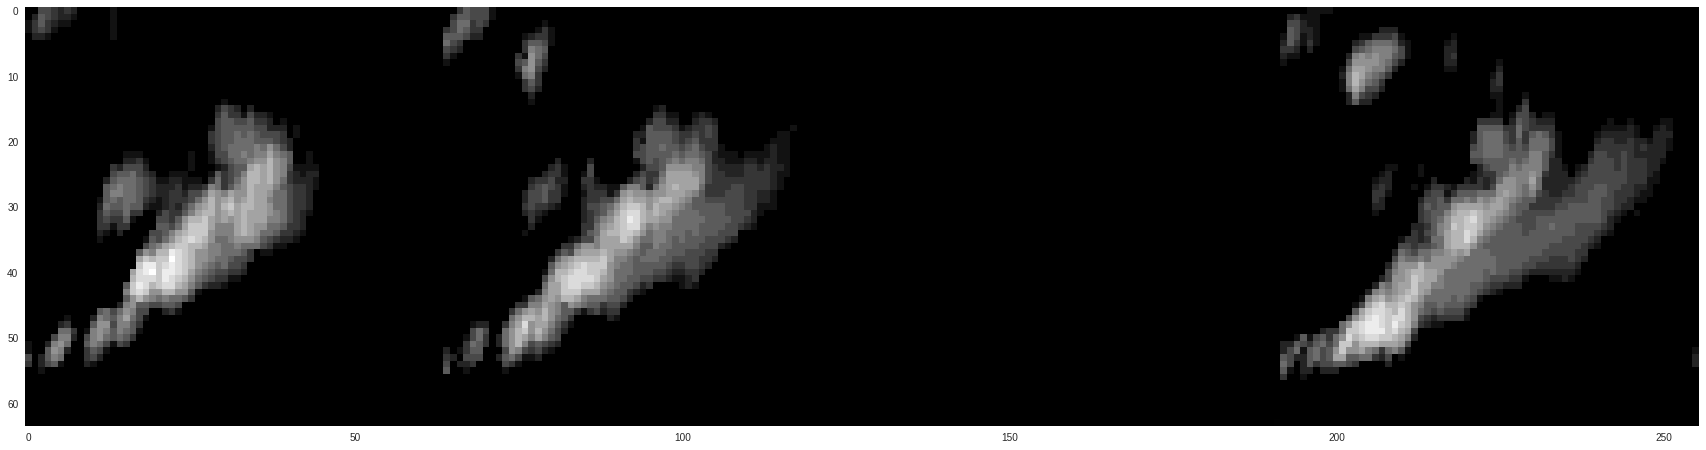

In [99]:
import matplotlib.pyplot as plt
def showImgGC(name,*img,folder=None):
	if len(img) == 0:
		return
	else:
		res = img[0]
		for i in img[1:]:
			res = np.concatenate((res,i),axis=1)
			
	fig, ax = plt.subplots(figsize=(30,30))
	ax.grid(False)
	ax.imshow(res.squeeze(), cmap='binary_r')
	if folder is not None:
		res = (res * 255).astype('int')
		cv.imwrite(folder+name+".png",res)

def compare(i,X,y,res,folder=None):
	showImgGC(str(i).zfill(2),X[i,0,:,:],y[i,0,:,:],res[i,0,:,:],X[i,1,:,:],folder=folder)

a = model(torch.tensor(X_test[0:10], dtype=torch.float).to(device))
compare(0, X_test, y_test, a.cpu().detach().numpy())